In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.linear_model import LinearRegression

In [2]:
DPI = 90
SAVE = False
label = ['gpu01', 'gpu02', 'gpu03', 'gpu04']

### Time

In [3]:
batch_sizes = np.arange(1, 513)
batch_sizes_4x = np.arange(4, 2049, 4)

In [4]:
te_32_1 = []
te_16_4 = []

for i in label:
    te_32_1.append(np.load(f'./temp/time_cResNetOld18_s32_b1_e512_g1_{i}.npy'))
    te_16_4.append(np.load(f'./temp/time_cResNetOld18_s16_b4_e2048_g4_{i}.npy'))

tb_32_1 = []
tb_16_4 = []
for i, j in zip(te_32_1, te_16_4):
    tb_32_1.append(i / np.ceil(50000 / batch_sizes))
    tb_16_4.append(j / np.ceil(50000 / batch_sizes_4x))

In [5]:
te_avg_32_1 = np.average(te_32_1, axis=0)
te_avg_16_4 = np.average(te_16_4, axis=0)

tb_avg_32_1 = np.average(tb_32_1, axis=0)
tb_avg_16_4 = np.average(tb_16_4, axis=0)

In [16]:
reg_model_32_1 = LinearRegression().fit(batch_sizes.reshape(-1,1), tb_avg_32_1)
reg_model_16_4 = LinearRegression().fit(batch_sizes_4x.reshape(-1,1), tb_avg_16_4)

print(reg_model_32_1.intercept_, reg_model_32_1.coef_)
print(reg_model_16_4.intercept_, reg_model_16_4.coef_)
print(reg_model_32_1.coef_ / reg_model_16_4.coef_)

0.012457569601358742 [0.00060355]
0.010772332781831706 [0.00026337]
[2.29167496]


In [7]:
tb_predict_32_1 = reg_model_32_1.predict(batch_sizes.reshape(-1,1))
tb_predict_16_4 = reg_model_16_4.predict(batch_sizes_4x.reshape(-1,1))

te_predict_32_1 = tb_predict_32_1 * np.ceil(50000 / batch_sizes)
te_predict_16_4 = tb_predict_16_4 * np.ceil(50000 / batch_sizes_4x)

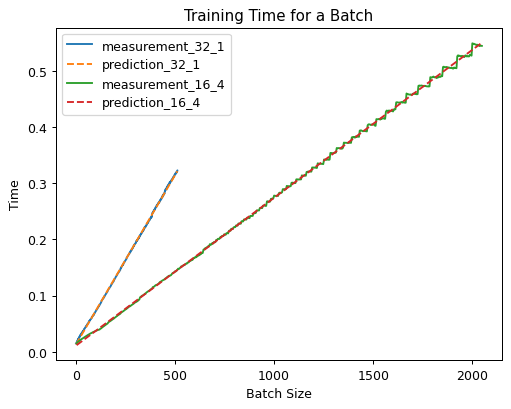

In [8]:
plt.figure(dpi=DPI)
plt.plot(batch_sizes, tb_avg_32_1, label='measurement_32_1')
plt.plot(batch_sizes, tb_predict_32_1, '--', label='prediction_32_1')
plt.plot(batch_sizes_4x, tb_avg_16_4, label='measurement_16_4')
plt.plot(batch_sizes_4x, tb_predict_16_4, '--', label='prediction_16_4')
plt.xlabel('Batch Size')
plt.ylabel('Time')
plt.title('Training Time for a Batch')
plt.legend()
if SAVE:
    plt.savefig('train_time_a_batch.png', transparent=True)
plt.show()

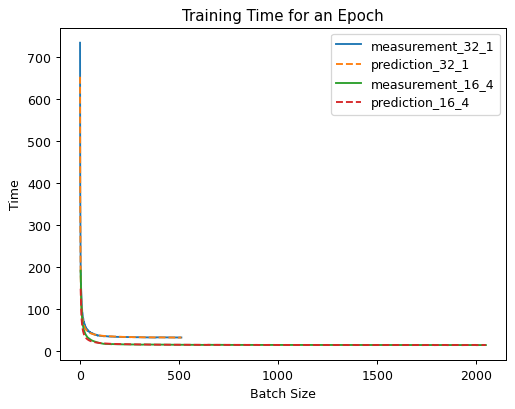

In [9]:
plt.figure(dpi=DPI)
plt.plot(batch_sizes, te_avg_32_1, label='measurement_32_1')
plt.plot(batch_sizes, te_predict_32_1, '--', label='prediction_32_1')
plt.plot(batch_sizes_4x, te_avg_16_4, label='measurement_16_4')
plt.plot(batch_sizes_4x, te_predict_16_4, '--', label='prediction_16_4')
plt.xlabel('Batch Size')
plt.ylabel('Time')
plt.title('Training Time for an Epoch')
plt.legend()
if SAVE:
    plt.savefig('train_time_an_epoch.png', transparent=True)
plt.show()

### Result

In [10]:
result_origin = []
result_progressive = []

'''
log = {
    'epoch': [],
    'batch_size': [],
    'time_cost': [],
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}
'''

for i in label:
    result_origin.append(np.load(f'./temp/results_origin_{i}.npy', allow_pickle=True).item())
    result_progressive.append(np.load(f'./temp/results_progressive_{i}.npy', allow_pickle=True).item())

In [11]:
result_origin_time_cum_sum = []
result_progressive_time_cum_sum = []

for i, j in zip(result_origin, result_progressive):
    result_origin_time_cum_sum.append(np.cumsum(i['time_cost']))
    result_progressive_time_cum_sum.append(np.cumsum(j['time_cost']))

In [12]:
acc_origin = []
acc_progressive = []

for i, j in zip(result_origin, result_progressive):
    acc_origin.append(i['test_acc'][-1])
    acc_progressive.append(j['test_acc'][-1])

print(np.average(acc_origin), np.max(acc_origin) - np.average(acc_origin))
print(np.average(acc_progressive), np.max(acc_progressive) - np.average(acc_progressive))

0.7231000000000001 0.0033999999999999586
0.722725 0.003775000000000084


In [13]:
time_origin = []
time_progressive = []

for i, j in zip(result_origin_time_cum_sum, result_progressive_time_cum_sum):
    time_origin.append(i[-1])
    time_progressive.append(j[-1])
    #print(i[-1], j[-1])

print(np.average(time_origin), np.max(time_origin) - np.average(time_origin))
print(np.average(time_progressive), np.max(time_progressive) - np.average(time_progressive))

4126.386912109376 73.2719511718733
3195.6024680175797 33.819344482421


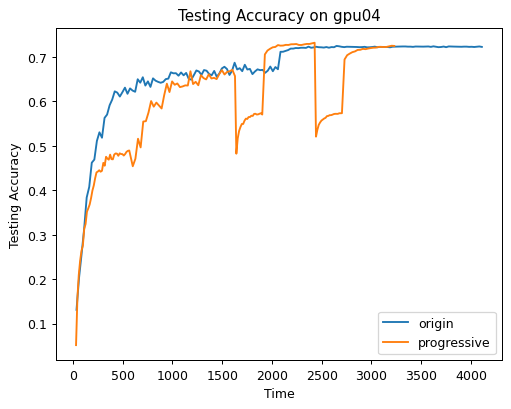

In [14]:
index = 3
plt.figure(dpi=DPI)
plt.plot(
    result_origin_time_cum_sum[index], result_origin[index]['test_acc'],
    label='origin', #linewidth=1
)
plt.plot(
    result_progressive_time_cum_sum[index], result_progressive[index]['test_acc'],
    label='progressive', #linewidth=1
)
plt.xlabel('Time')
plt.ylabel('Testing Accuracy')
plt.title(f'Testing Accuracy on gpu0{index+1}')
plt.legend()
if SAVE:
    plt.savefig(f'result_acc_gpu0{index+1}.png', transparent=True)
plt.show()

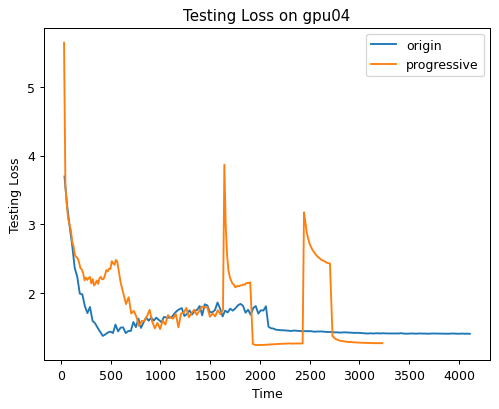

In [15]:
index = 3
plt.figure(dpi=DPI)
plt.plot(
    result_origin_time_cum_sum[index], result_origin[index]['test_loss'],
    label='origin', #linewidth=1
)
plt.plot(
    result_progressive_time_cum_sum[index], result_progressive[index]['test_loss'],
    label='progressive', #linewidth=1
)
plt.xlabel('Time')
plt.ylabel('Testing Loss')
plt.title(f'Testing Loss on gpu0{index+1}')
plt.legend()
if SAVE:
    plt.savefig(f'result_loss_gpu0{index+1}.png', transparent=True)
plt.show()